# Modelos de Difusão com BreastMNIST

Este notebook demonstra como treinar duas redes de difusão não condicionais (**DDPM**) utilizando o dataset **BreastMNIST** do MedMNIST.
O procedimento segue a mesma preparação do notebook `gan_classical_medmnist`, porém substituindo as GANs por modelos de difusão.
Treinaremos um modelo para a classe 0 e outro para a classe 1.


<img src="diffusion.ppm" alt="Minha Figura" width="800"/>


## 1. Setup e Importações
Instale as dependências necessárias e carregue as principais bibliotecas utilizadas ao longo do notebook.

In [6]:
# de dentro de /workspace/QuantumGANs_MedMNIST
!git clone https://github.com/huggingface/diffusers.git; cd diffusers; pip install -e .[training]; pip install -r examples/unconditional_image_generation/requirements.txt


Cloning into 'diffusers'...
remote: Enumerating objects: 103480, done.
remote: Counting objects: 100% (1126/1126), done.
remote: Compressing objects: 100% (610/610), done.
remote: Total 103480 (delta 923), reused 515 (delta 515), pack-reused 102354 (from 2)
Receiving objects: 100% (103480/103480), 77.96 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (76322/76322), done.
Updating files: 100% (2170/2170), done.
Obtaining file:///workspace/QuantumGANs_MedMNIST/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 207.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 331.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 301.1 MB/s eta 0:00:00
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffu

In [1]:
# Instalação de dependências
!pip install -q diffusers accelerate medmnist datasets torchvision
!pip install torchmetrics[image] torch-fidelity


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
from accelerate.utils import write_basic_config
write_basic_config()
import os
from pathlib import Path
from medmnist import BreastMNIST
from PIL import Image

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


## 2. Carregamento e Preparação do Dataset

In [2]:
data_dir = Path('data/breastmnist')
class0_dir = data_dir / 'class0'
class1_dir = data_dir / 'class1'
class0_dir.mkdir(parents=True, exist_ok=True)
class1_dir.mkdir(parents=True, exist_ok=True)

train_dataset = BreastMNIST(split='train', download=True)
imgs, labels = train_dataset.imgs, train_dataset.labels.flatten()
for idx, (img, label) in enumerate(zip(imgs, labels)):
    if label == 0:
        Image.fromarray(img.squeeze()).save(class0_dir / f'{idx}.png')
    elif label == 1:
        Image.fromarray(img.squeeze()).save(class1_dir / f'{idx}.png')


## 3. Treinamento do modelo

In [9]:
!pip install wandb; wandb login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 146.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 172.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [7]:
accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/breastmnist/class0 \
  --resolution 32 \
  --output_dir ddpm_breastmnist_class0 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb


!accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/breastmnist/class1 \
  --resolution 32 \
  --output_dir ddpm_breastmnist_class1 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb


09/09/2025 12:17:49 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

Resolving data files: 100%|████████████████| 147/147 [00:00<00:00, 18445.60it/s]
Generating train split: 147 examples [00:00, 16914.37 examples/s]
09/09/2025 12:17:52 - INFO - __main__ - Dataset size: 147
09/09/2025 12:17:53 - INFO - __main__ - ***** Running training *****
09/09/2025 12:17:53 - INFO - __main__ -   Num examples = 147
09/09/2025 12:17:53 - INFO - __main__ -   Num Epochs = 100
09/09/2025 12:17:53 - INFO - __main__ -   Instantaneous batch size per device = 64
09/09/2025 12:17:53 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 64
09/09/2025 12:17:53 - INFO - __main__ -   Gradient Accumulation steps = 1
09/09/2025 12:17:53 - INFO - __main__ -   Total optimization steps = 300
Epoch 0:   0%|                                            | 0/3 [00:00<?, ?it/s]T

## 4. Gerar imagens/ Observar resultados

In [4]:
import torch
from diffusers import DDPMPipeline
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

@torch.no_grad()
def compare_generated_real_grid_diffusers(
    malignant_dir="ddpm_breastmnist_class0",
    benign_dir="ddpm_breastmnist_class1",
    device="cuda",
    dataset=None,
    num_samples=3,
    num_inference_steps=50,
    torch_dtype=torch.float16,   # use torch.float32 se fp16 não for suportado
    seed=None
):
    assert dataset is not None, "Forneça o dataset usado no treino (ou equivalente)."

    # Reprodutibilidade opcional
    g = torch.Generator(device=device)
    if seed is not None:
        g.manual_seed(seed)

    # Carrega pipelines
    pipe_mal = DDPMPipeline.from_pretrained(malignant_dir, torch_dtype=torch_dtype).to(device)
    pipe_ben = DDPMPipeline.from_pretrained(benign_dir, torch_dtype=torch_dtype).to(device)
    pipe_mal.set_progress_bar_config(disable=True)
    pipe_ben.set_progress_bar_config(disable=True)

    # Gera sintéticas (listas de PIL)
    fake_mal_pil = pipe_mal(batch_size=num_samples, num_inference_steps=num_inference_steps, generator=g).images
    fake_ben_pil = pipe_ben(batch_size=num_samples, num_inference_steps=num_inference_steps, generator=g).images

    # --- helpers ---
    def pil_to_tensor01(img: Image.Image) -> torch.Tensor:
        """PIL -> tensor CxHxW em [0,1]"""
        arr = np.array(img)  # HxW ou HxWxC, dtype uint8
        if arr.ndim == 2:  # grayscale
            arr = arr[:, :, None]
        t = torch.from_numpy(arr).float() / 255.0
        t = t.permute(2, 0, 1)  # CxHxW
        return t

    def any_to_tensor01(x):
        """Converte PIL/np/tensor para tensor CxHxW em [0,1]. 
           Se estiver em [-1,1], remapeia para [0,1]."""
        if isinstance(x, Image.Image):
            t = pil_to_tensor01(x)
        elif isinstance(x, np.ndarray):
            if x.ndim == 2:
                x = x[:, :, None]
            t = torch.from_numpy(x).float()
            if t.max() > 1.0:  # provavelmente 0-255
                t = t / 255.0
            t = t.permute(2, 0, 1) if t.ndim == 3 else t.unsqueeze(0)
        elif torch.is_tensor(x):
            t = x.detach().float()
            if t.ndim == 2:     # HxW
                t = t.unsqueeze(0)
            # normaliza range
            if t.min() < 0.0:   # típico [-1,1]
                t = (t + 1) * 0.5
            elif t.max() > 1.0: # típico 0-255
                t = t / 255.0
        else:
            raise TypeError(f"Tipo não suportado: {type(x)}")
        return t.clamp(0, 1)

    def first_channel_to_hw01(t: torch.Tensor) -> np.ndarray:
        """Pega canal 0 e retorna HxW em [0,1] numpy."""
        if t.ndim == 3 and t.shape[0] > 1:
            t = t[0]
        elif t.ndim == 3:
            t = t.squeeze(0)
        return t.cpu().numpy()

    # Converte sintéticas para tensors [0,1]
    fake_mal_t = [any_to_tensor01(img) for img in fake_mal_pil]
    fake_ben_t = [any_to_tensor01(img) for img in fake_ben_pil]

    # Separa reais por classe (dataset pode devolver PIL/torch)
    real_mal_all, real_ben_all = [], []
    for img, label in dataset:
        y = int(label if isinstance(label, int) else label.item())
        if y == 0:
            real_mal_all.append(img)
        elif y == 1:
            real_ben_all.append(img)

    if len(real_mal_all) < num_samples or len(real_ben_all) < num_samples:
        raise ValueError(f"Amostras insuficientes: mal={len(real_mal_all)}, ben={len(real_ben_all)}.")

    real_mal = random.sample(real_mal_all, num_samples)
    real_ben = random.sample(real_ben_all, num_samples)

    # Converte reais para [0,1] tensor
    real_mal_t = [any_to_tensor01(x) for x in real_mal]
    real_ben_t = [any_to_tensor01(x) for x in real_ben]

    # --- plot ---
    fig, axes = plt.subplots(nrows=num_samples, ncols=4, figsize=(12, 3 * num_samples))

    for i in range(num_samples):
        imgs = [
            first_channel_to_hw01(fake_mal_t[i]),
            first_channel_to_hw01(real_mal_t[i]),
            first_channel_to_hw01(fake_ben_t[i]),
            first_channel_to_hw01(real_ben_t[i]),
        ]
        titles = ["Gerada Malignant", "Real Malignant", "Gerada Benign", "Real Benign"]

        for j in range(4):
            ax = axes[i, j] if num_samples > 1 else axes[j]
            ax.imshow(imgs[j], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            for side in ['top', 'bottom', 'left', 'right']:
                ax.spines[side].set_visible(True)
                ax.spines[side].set_linewidth(1)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)

    plt.tight_layout()
    plt.show()


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

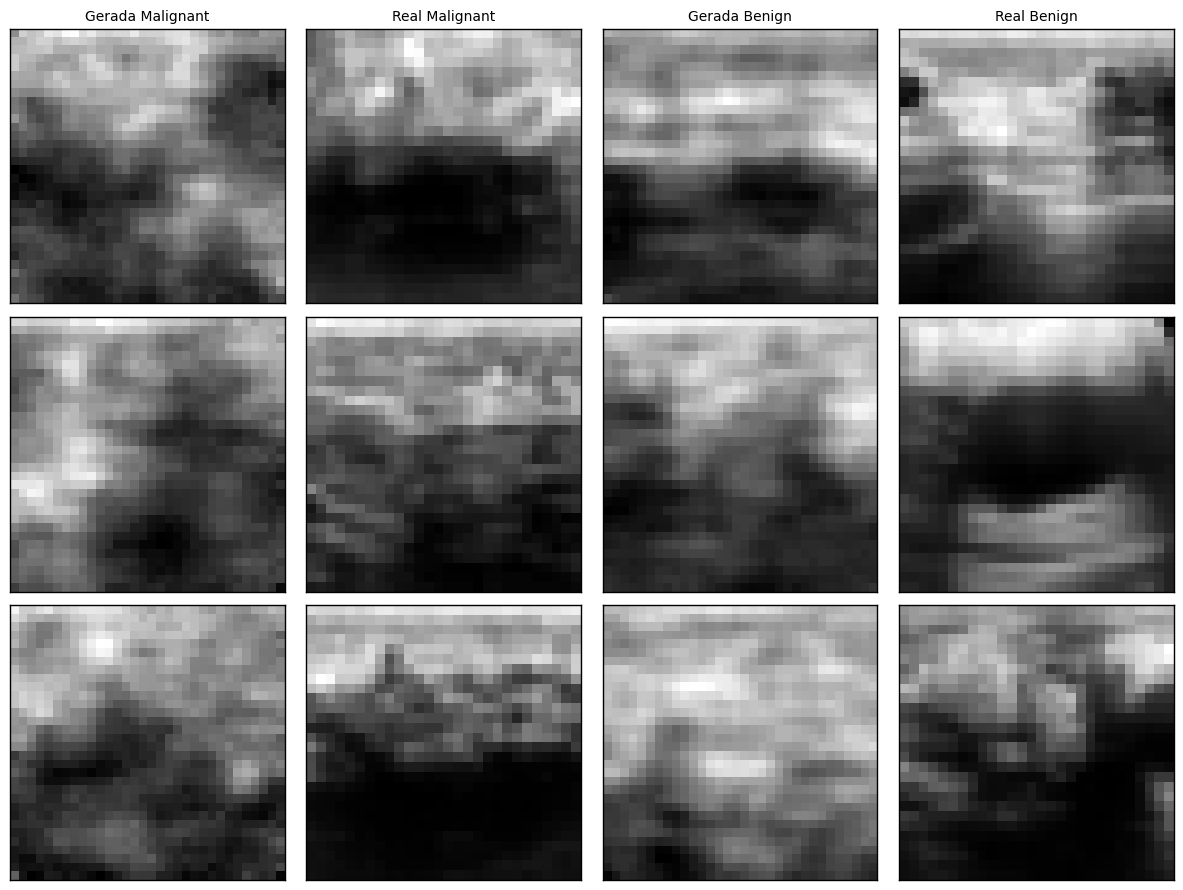

In [5]:
compare_generated_real_grid_diffusers(
     malignant_dir="ddpm_breastmnist_class0",
     benign_dir="ddpm_breastmnist_class1",
     device="cuda",
     dataset=train_dataset,
     num_samples=3,
     num_inference_steps=50,
     torch_dtype=torch.float16,
     seed=42
)

## 5. Avaliação com Métricas
Avaliamos as imagens geradas utilizando as métricas **FID** e **Inception Score**, disponíveis no pacote `torchmetrics`.

### Frechet Inception Distance (FID)


$\mathrm{FID} = \|\mu_r - \mu_g\|^2 + \operatorname{Tr}\left( \Sigma_r + \Sigma_g - 2 \left( \Sigma_r \Sigma_g \right)^{1/2} \right)$


onde:
- $\mu_r$ = média das features reais
- $\mu_g$ = média das features geradas
- $\Sigma_r$ = covariância das features reais
- $\Sigma_g$ = covariância das features geradas

---

### Inception Score (IS)

$ \mathrm{IS} = \exp \left( \mathbb{E}_x \left[ D_{\mathrm{KL}}\left( p(y|x) \;||\; p(y) \right) \right] \right) $

onde:
- $p(y|x)$ = distribuição predita para a imagem gerada
- $p(y)$ = distribuição marginal $p(y) = \int p(y|x) p(x) dx$
- $\mathbb{E}_x$: valor esperado sobre as imagens geradas (média)
- $D_{\mathrm{KL}}$: divergência de Kullback-Leibler


In [8]:
import torch
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from diffusers import DDPMPipeline
from PIL import Image
import numpy as np
import pandas as pd

# ---- helpers de conversão ----
def pil_to_tensor01(img: Image.Image) -> torch.Tensor:
    arr = np.array(img)
    if arr.ndim == 2:
        arr = arr[:, :, None]
    t = torch.from_numpy(arr).float() / 255.0  # H,W,C -> [0,1]
    return t.permute(2, 0, 1)                  # C,H,W

def any_to_tensor01(x) -> torch.Tensor:
    if isinstance(x, Image.Image):
        t = pil_to_tensor01(x)
    elif isinstance(x, np.ndarray):
        if x.ndim == 2:
            x = x[:, :, None]
        t = torch.from_numpy(x).float()
        if t.max() > 1.0:
            t = t / 255.0
        t = t.permute(2,0,1) if t.ndim == 3 else t.unsqueeze(0)
    elif torch.is_tensor(x):
        t = x.detach().float()
        if t.ndim == 2:
            t = t.unsqueeze(0)
        if t.min() < 0.0:
            t = (t + 1) * 0.5
        elif t.max() > 1.0:
            t = t / 255.0
    else:
        raise TypeError(f"Tipo não suportado: {type(x)}")
    return t.clamp(0,1)

def to_uint8_3ch_299(t01: torch.Tensor) -> torch.Tensor:
    if t01.shape[0] == 1:
        t01 = t01.repeat(3,1,1)
    elif t01.shape[0] > 3:
        t01 = t01[:3]
    t = t01.unsqueeze(0)  # 1,C,H,W
    t = F.interpolate(t, size=(299,299), mode='bilinear', align_corners=False)
    return (t.clamp(0,1) * 255.0).round().to(torch.uint8)  # 1,3,299,299

# ---- collate que converte PIL->tensor ----
def collate_to_tensor(batch):
    imgs, labels = zip(*batch)  # listas
    imgs_t = [any_to_tensor01(x) for x in imgs]     # cada um C,H,W [0,1]
    labels_t = []
    for y in labels:
        if torch.is_tensor(y):
            labels_t.append(y.long().view(-1)[0])
        else:
            labels_t.append(torch.tensor(int(y), dtype=torch.long))
    return torch.stack(imgs_t, dim=0), torch.stack(labels_t, dim=0)

@torch.no_grad()
def evaluate_diffusion_pipeline(
    pipeline_dir: str,
    device: str,
    dataset,
    label_target: int,
    gen_label_name: str,
    batch_size: int = 64,
    max_batches: int = 10,
    num_inference_steps: int = 50,
    use_fp16: bool = True
):
    fid = FrechetInceptionDistance(feature=64).to(device)
    is_metric = InceptionScore().to(device)

    pipe = DDPMPipeline.from_pretrained(
        pipeline_dir,
        torch_dtype=(torch.float16 if use_fp16 else torch.float32)
    ).to(device)
    pipe.set_progress_bar_config(disable=True)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_to_tensor,  # <- aqui está a diferença
        num_workers=0
    )

    batch_count = 0
    for real, labels in loader:
        # real: (B,C,H,W) em [0,1], labels: (B,)
        mask = (labels == label_target)
        if mask.sum().item() == 0:
            continue

        real_sel = real[mask]  # (b_sel,C,H,W)
        b_size = real_sel.size(0)
        if b_size == 0:
            continue

        # gera b_size imagens (lista de PIL)
        gen = pipe(batch_size=int(b_size), num_inference_steps=num_inference_steps).images

        # reais -> uint8 3x299x299 no device
        real_uint8 = torch.cat([to_uint8_3ch_299(x) for x in real_sel], dim=0).to(device)

        # fakes -> uint8 3x299x299 no device
        fake_uint8 = torch.cat([to_uint8_3ch_299(any_to_tensor01(x)) for x in gen], dim=0).to(device)

        # métricas
        fid.update(real_uint8, real=True)
        fid.update(fake_uint8, real=False)
        is_metric.update(fake_uint8)

        batch_count += 1
        if batch_count >= max_batches:
            break

    fid_score = float(fid.compute().item())
    is_mean, is_std = is_metric.compute()
    is_mean = float(is_mean.item() if torch.is_tensor(is_mean) else is_mean)
    is_std  = float(is_std.item() if torch.is_tensor(is_std) else is_std)

    return {
        'Model': 'DDPM',
        'Generator_Label': gen_label_name.capitalize(),
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean,
        'IS_Std': is_std
    }


In [10]:
results = []

results.append(evaluate_diffusion_pipeline(
    pipeline_dir="ddpm_breastmnist_class0",
    device=device,
    dataset=train_dataset,
    label_target=0,
    gen_label_name='malignant',
    batch_size=64, max_batches=10, num_inference_steps=50, use_fp16=True
))

results.append(evaluate_diffusion_pipeline(
    pipeline_dir="ddpm_breastmnist_class1",
    device=device,
    dataset=train_dataset,
    label_target=1,
    gen_label_name='benign',
    batch_size=64, max_batches=10, num_inference_steps=50, use_fp16=True
))

df_results = pd.DataFrame(results)
df_results


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_8776/2741698916.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_t.append(torch.tensor(int(y), dtype=torch.long))


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

,Model,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,DDPM,Malignant,Malignant,1.111613,1.396093,0.087010
1,DDPM,Benign,Benign,1.076977,1.746250,0.078355


## Classificação com a ResNet-18